# Init

In [94]:
from skimage.transform import hough_line, hough_line_peaks
from skimage import io, color, feature, transform, filters
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.feature import canny
import cv2 as cv
import ipywidgets
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy
import seaborn as sns
import sklearn.cluster

In [95]:
sns.set(style='dark')
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['image.cmap'] = 'viridis'
np.set_printoptions(threshold=20, edgeitems=10, linewidth=140, precision=3, suppress=True)

# Task 0: Load `sudoku-alt3.jpg` and detect edges using the Canny method

In [96]:
#read the image file using skimage
image = io.imread('sudoku-alt3.jpg')

#convert the image to grayscale
gray = color.rgb2gray(image)

#apply the Canny edge detector
edges = feature.canny(gray, sigma=0.7)

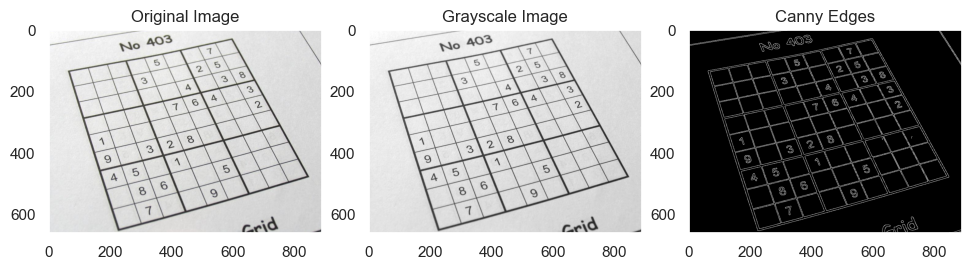

In [97]:
fig, axes = plt.subplots(1, 3, figsize=plt.figaspect(0.5))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[1].imshow(gray, cmap='gray', vmin=0, vmax=1)
axes[1].set_title('Grayscale Image')
axes[2].imshow(edges, cmap='gray', vmin=0, vmax=1)
axes[2].set_title('Canny Edges')
plt.show()

# Task 1: find the 4 border lines of the sudoku grid

Use the Hough transform to detect grid lines of the sudoku. We only are interested in the border lines that outline the grid - the other ones inside the grid do not matter.
- The Hough transform will probably return the lines inside the grid as well.
- Separate horizontal and vertical lines. Horizontal lines will have angles close to $\pm\pi/2$, vertical ones close to $0$ (details depend on whether you use scikit-image or OpenCV).
- The top most line will be the horizontal line with the smallest distance from the origin. The bottom-most line will be the horizontal line with the largest distance from the origin.
- In a similar manner, you can identify the left-most and right-most vertical lines as well.

In [98]:
gray = color.rgb2gray(image)
blurred = filters.gaussian(gray, sigma=0.75)
edges = feature.canny(blurred, sigma=0.67)

tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
h, theta, d = transform.hough_line(edges, theta=tested_angles)

lines = transform.hough_line_peaks(h, theta, d, threshold=0.37*h.max(), min_distance=20, min_angle=10)

hor_lines = []
ver_lines = []

for _, angle, dist in zip(*lines):
    if angle < np.pi / 4 or angle > 3*np.pi / 4:
        ver_lines.append((dist, angle))
    else:
        hor_lines.append((dist, angle))

hor_lines = sorted(hor_lines, key=lambda x: x[0])
ver_lines = sorted(ver_lines, key=lambda x: x[0])

top_line = hor_lines[1] 
bottom_line = hor_lines[-1]
left_line = ver_lines[0]
right_line = ver_lines[-1]

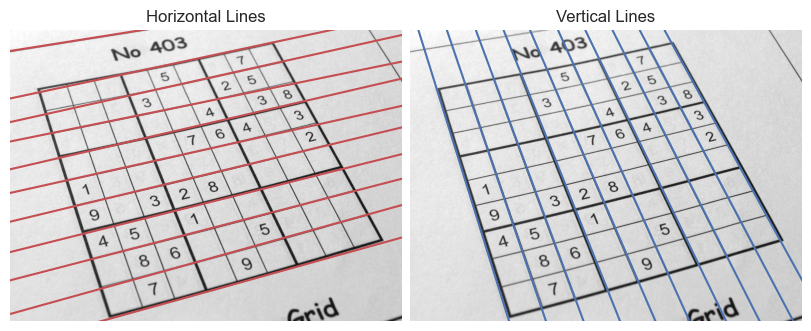

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5), sharex=True, sharey=True)

for dist, angle in hor_lines:
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - gray.shape[1] * np.cos(angle)) / np.sin(angle)
    axes[0].plot((0, gray.shape[1]), (y0, y1), '-r')
axes[0].set_title('Horizontal Lines')
axes[0].imshow(gray, cmap='gray')

for dist, angle in ver_lines:
    x0 = (dist - 0 * np.sin(angle)) / np.cos(angle)
    x1 = (dist - gray.shape[0] * np.sin(angle)) / np.cos(angle)
    axes[1].plot((x0, x1), (0, gray.shape[0]), '-b')
axes[1].set_title('Vertical Lines')
axes[1].imshow(gray, cmap='gray')

for ax in axes:
    ax.axis('off')
plt.show()


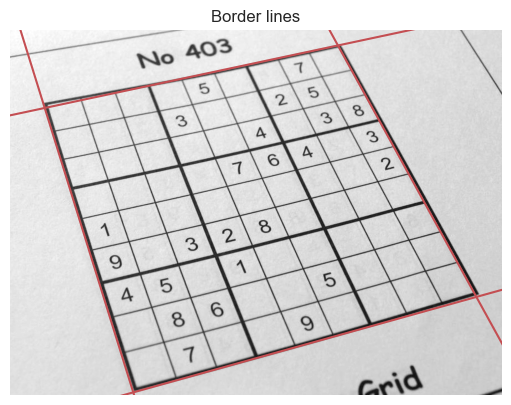

In [100]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(gray, cmap=plt.cm.gray)

border_lines = [top_line, bottom_line, left_line, right_line]

for dist, angle in border_lines:
    if np.abs(angle) < np.pi / 4:
        y0 = 0
        y1 = gray.shape[0]
        x0 = (dist - y0 * np.sin(angle)) / np.cos(angle)
        x1 = (dist - y1 * np.sin(angle)) / np.cos(angle)
    else:
        x0 = 0
        x1 = gray.shape[1]
        y0 = (dist - x0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
    ax.plot((x0, x1), (y0, y1), '-r')

ax.set_xlim((0, gray.shape[1]))
ax.set_ylim((gray.shape[0], 0))
ax.set_axis_off()
ax.set_title('Border lines')

plt.show()


# Task 2: implement the `line_intersect` function

Define a function for line-line intersection. You can calculate an intersection of two lines $(a_1, b_1, c_1)$ and $(a_2, b_2, c_2)$ in standard form as
$$
\begin{split}
(x, y, z) & = (a_1, b_1, c_1) \times (a_2, b_2, c_2) \\
          & = (b_1c_2 - b_2c_1, a_2c_1 - a_1c_2, a_1b_2 - a_2b_1)
\end{split}
$$
where
- $\times$ denotes the [cross product](https://en.wikipedia.org/wiki/Cross_product) of the two vectors,
- $(x, y, z)$ are the unnormalized homogennous corrdinates of the intersection point. To get the final cartesian 2D corrdinates $(x', y')$, divide by $z$:
$$
(x', y') = \left(\frac{x}{z}, \frac{y}{z}\right)
$$
You can use the function [`numpy.cross`](https://numpy.org/doc/stable/reference/generated/numpy.cross.html) from the numpy library for computing the cross product.

Remember that from the Hough transform and the subsequent clustering we got the lines in polar coordinates, i.e. in the form
$$
x \cdot \cos \theta + y \cdot \sin \theta - r = 0
$$
so you first need to convert into the standard $(a,b,c)$ form
$$
a \cdot x + b \cdot y + c = 0
$$

In [101]:
import numpy as np

def line_intersect(dist1, angle1, dist2, angle2):
    a1, b1, c1 = np.cos(angle1), np.sin(angle1), -dist1
    a2, b2, c2 = np.cos(angle2), np.sin(angle2), -dist2

    line1 = np.array([a1, b1, c1])
    line2 = np.array([a2, b2, c2])

    x, y, z = np.cross(line1, line2)

    if z == 0:
        return None
    x, y = x / z, y / z
    return (x, y)


# Task 3: use the `line_intersect` function to detect the 4 corners of the sudoku table

Create a $4 \times 2$ matrix `corners`, which will be
$$
\bold{C} = \begin{bmatrix}
x_\textrm{tl} & y_\textrm{tl} \\
x_\textrm{tr} & y_\textrm{tr} \\
x_\textrm{br} & y_\textrm{br} \\
x_\textrm{bl} & y_\textrm{bl}
\end{bmatrix}
$$

Corners of the Sudoku table:
[[ 62.768 141.013]
 [592.995  27.986]
 [843.278 482.684]
 [222.91  655.231]]


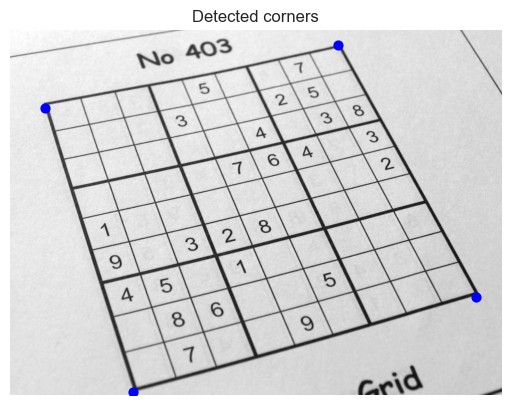

In [102]:
corners = np.array([[xtl, ytl], [xtr, ytr], [xbr, ybr], [xbl, ybl]])
print("Corners of the Sudoku table:")
print(corners)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(gray, cmap=plt.cm.gray)

corner_x = corners[:, 0]
corner_y = corners[:, 1]
ax.scatter(corner_x, corner_y, color='blue', s=40)

ax.set_xlim([0, gray.shape[1]])
ax.set_ylim([gray.shape[0], 0])
ax.axis('off')
ax.set_title('Detected corners')
plt.show()


# Task 4: extract and align the sudoku grid to standard size and coordinates

Take the code from `geom-transform` notebook and use the computed corner positions instead of the manually specified ones.

In [103]:
side_length = 480
dst_points = np.array([[0, 0], [side_length - 1, 0], [side_length - 1, side_length - 1], [0, side_length - 1]])
src_points = np.array(corners, dtype=np.float32)
tform = transform.estimate_transform('projective', src_points, dst_points)
warped_img = transform.warp(image, inverse_map=tform.inverse, output_shape=(side_length, side_length))


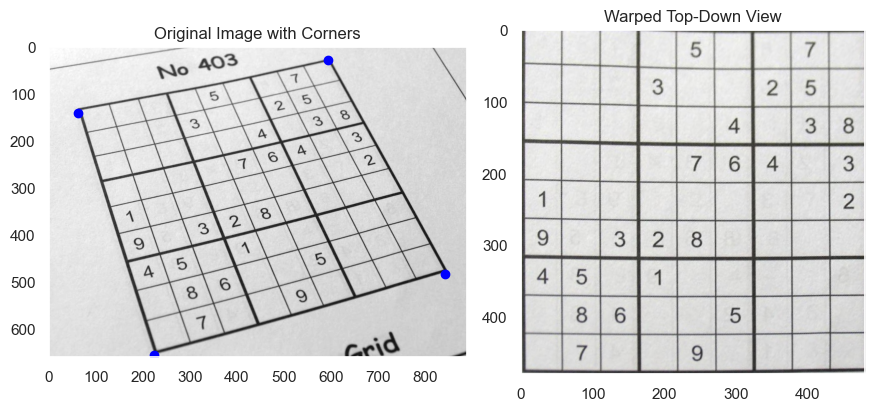

In [104]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

axes[0].imshow(gray, cmap='gray')
axes[0].scatter(corners[:, 0], corners[:, 1], color='blue')
axes[0].set_title('Original Image with Corners')
axes[0].axis('on')

axes[1].imshow(warped_img, cmap='gray')
axes[1].set_title('Warped Top-Down View')
axes[1].axis('on')

plt.show()
